# NLP and the Web: Home Exercise 4

_**Regarding types, documentation, and output:**_

_We tried to make the description of the parameters as clear as possible. However, if you believe that something is missing, please reach out to us in Moodle. We provide type hints for the function parameters and return values of the functions that you have to implement. These are suggestions only, and you may use different types if you prefer._

_Nevertheless, your code must use the provided method stubs and parameters. Furthermore, make sure that your code runs without errors and in a reasonable amount of time, for example by using "Kernel/Restart & Run All" before submitting._

_Please use comments where appropriate to help the tutors understand your code. This is especially important for the more extensive exercises later on. Finally, please pay attention to how you output the results. We highly recommend using `display(df)` for displaying data frames._

_**Please only modify the template in the specified markdown and code cells (e.g. YOUR CODE / ANSWER / IMPORTS HERE). Some cells are left blank on purpose. Please do not modify these cells, because they are used to autograde your submission. If these cells are modified, the automatic grading for your submission will fail. Please do not modify the cells containing public and private tests. If you want to do your own tests, please use the code cell containing your code solution (YOUR CODE HERE).**_

In [1]:
# for type-hinting
from numpy import ndarray
from typing import Union, List, Dict, DefaultDict, Set
# Bunch is a subtype of Dict, so the type-hints are comparable to Dict type-hints: Bunch[key, value]
from sklearn.utils import Bunch

## Task 1: Inverted Index / Boolean Retrieval (5 Points)

__a)__ (0.5 Points) Next to many useful machine learning tools, __sklearn__ includes a collection of various datasets. In the ungraded practice notebook, you have already seen some examples on how to work with _20newsgroups_ ([dataset](https://scikit-learn.org/stable/datasets/real_world.html#newsgroups-dataset), [loader](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html)) which is a useful text corpus with numerous documents for a total of 20 different topics. For this notebook, we will use a selection of documents from the _20newsgroups_ dataset as our example corpus. Fetch all documents from _20newsgroups_ that adhere to the following parameters: 
- Include only documents of the 'test' subset and from the provided categories
- The documents should be shuffled with a random seed of 42
- Headers, footers and quotes should be removed  

To save some processing time in the following tasks, we want to further reduce our corpus. For this purpose, keep only the first 300 documents of the fetched result as your final corpus in a variable called __docs__ of type __list[str]__. Additionally, store the corresponding 300 target labels (categories) in a separate variable called __targets__ of type __ndarray__.

In [2]:
from sklearn.datasets import fetch_20newsgroups
categoriess: List[str] = ['alt.atheism', 'rec.sport.hockey']

data=fetch_20newsgroups(subset='test',random_state=42,remove=('headers', 'footers', 'quotes'),categories=categoriess)
# first 300 docs and corresponding labels
docs: list[str] = data['data'][:300]
targets: ndarray = data['target'][:300]
    
# YOUR CODE HERE

    

In [3]:
# Test
assert sum(targets) == 177
assert '\nPersonal attacks?' in docs[0]
assert type(targets) == ndarray
assert type(docs) == list

__b)__ (2 Points) Implement a function `inverted_index` that receives a list of documents and returns an inverted index. An inverted index is a key-value mapping where each key is a unique word from the vocabulary of a given corpus of documents. Each key maps to a postings list that contains the indices of all documents in which the key word occurs in at least once. The index should cover only c (i.e. you should lemmatize tokens before adding them to the inverted index) that fully consist of alphabetic characters. For lemmas/keys that are not covered by the corpus vocabulary, the resulting index should return an empty list (_hint_: defaultdict). You are also allowed to return an empty list for pronouns. The type of the return should be:                     __defaultdict[str, list[int]]__

Use your function to create an inverted index for the corpus from task 1a) and output the postings lists for the terms "skate", "faith" and "pizza" and store it in variables skate_indices, faith_indices and pizza_indices of the type __list[int]__.
Only use __spaCy__ for tokenization, lemmatization and detection of alphabetic tokens!

In [4]:
import spacy
from collections import defaultdict
nlp: spacy.Language = spacy.load("en_core_web_sm")

In [5]:
def inverted_index(docs: Union[List[str], List[spacy.tokens.Doc]]) -> DefaultDict[str, List[int]]:
    """Create an inverted index for a given corpus of documents
    
    :param docs: array-like object containing documents
                 (List[spacy.tokens.Doc] or List[str] are only suggestions 
                  - you may choose either of both or another suitable type)
    :return:defaultdict[str, list[int]] inverted index 
    """
    def def_value():
        return []
    docs=[nlp(doc) for doc in docs]
    inverted_index: DefaultDict[str, List[int]] = defaultdict(def_value)
    for index,doc in enumerate(docs):
        uniques = list(set([keyword.lemma_ for keyword in doc if keyword.text.isalpha() == True]))
        for lemma in uniques:
            inverted_index[lemma].append(index)

    
    # YOUR CODE HERE
    return inverted_index


wordPos=inverted_index(docs)
skate_indices: list[int] = wordPos['skate']
faith_indices: list[int] = wordPos['faith']
pizza_indices: list[int] = wordPos['pizza']

# YOUR CODE HERE



In [6]:
# Test

assert 250 in skate_indices
assert 202 in faith_indices
assert type(inverted_index(docs)) == defaultdict


__c)__ (2.5 Points) Implement the optimized intersection function `intersect([t1, ..., tn])` for multiple AND queries from the lecture (slide 52). Try to keep the implementation as close as possible to the given pseudocode (see picture in the cell below).

Afterwards, create a function `boolean_retrieval` that takes a list of terms and interprets them as an AND query (e.g., the input ["best", "pizza", "pie"] should be interpreted as "best AND pizza AND pie"). The return value of the function should be a __list[int]__ of all document indices that contain all of the query tokens. 

Apply the function `boolean_retrieval` for the following queries and output the number of retrieved documents for each query:  

- best AND goals
- best AND goals AND overtime
- religions 
- most AND common AND religions

_Hints_: 

* Use the inverted index from the previous exercise to access the postings in lines 2 and 5 of the pseudocode. The function `intersect_(postings1, postings2)` that is used in line 5 of the pseudocode is already implemented for you. 
* You should pre-process the query within the function `boolean_retrieval`.

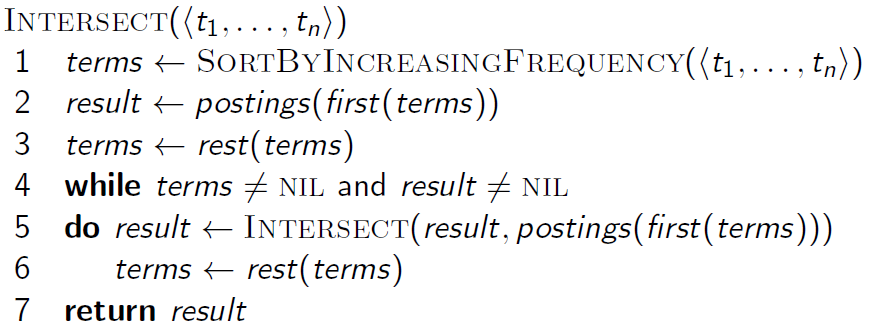

In [7]:
def intersect(terms: List[str]) -> List[int]:
    """Intersect the postings lists for multiple query terms as shown in the above pseudocode
    
    The intersection stops early if one of 2 conditions is fulfilled (see line 4 above).
    
    :param terms: array-like object containing terms, e.g. ['good', 'pizza', 'darmstadt']  
    :return: List[int] containing indices of documents in which all query terms occur 
    """
    wordPos=inverted_index(docs)
    result: List[int] = []
    terms=sort_by_increasing_frequency(terms)
    result = wordPos[terms[0]]
    terms = terms[1:]
    while len(terms)>0 and len(result)>0:
        result= intersect_(result,wordPos[terms[0]])
        terms = terms[1:]
    # YOUR CODE HERE
    
    return result

def sort_by_increasing_frequency(terms: List[str]) -> List[str]:
    """Sort terms by the length of their postings lists. Used in line 1 of the pseudocode
    
    E.g.: assume we have the following 3 words: 
        * "pizza" (in 10 documents)
        * "sushi" (in 3 documents)
        * "schnitzel" (in 15 documents)
        The outputed list should be: ["sushi", "pizza", "schnitzel"]
    
    :param terms: array-like object containing terms
    :return: List[str] containing terms, ordered increasingly by their document frequency
    """
    wordPos=inverted_index(docs)
    terms=[(term,len(wordPos[term])) for term in terms]
    terms= sorted(terms, key=lambda tup: tup[1])
    result: List[str] = [term[0] for term in terms]
    print(terms)
    # YOUR CODE HERE

    return result

def intersect_(postings1: List[int], postings2: List[int]) -> List[int]:
    """Intersect two (sub)lists containing postings. Used in line 5 of the pseudocode
    
    This function is already implemented and ready to use.
    
    :param postings1: array-like object containing the postings list of a term
    :param postings2: array-like object containing the postings list of a term
    :return: List[int] containing intersection of postings1 and postings2
    """
    return list(set(postings1) & set(postings2))

def boolean_retrieval(query: List[str]) -> List[int]:
    """Perform Boolean retrieval for a given query to determine all relevant documents
    
    :param query: array-like object containing query terms, e.g. ["my", "query"]
    :return: List[int] containing document indices that fulfill the conjunction of all query terms
    """
    
    result: List[str] = intersect([word.lemma_ for word in nlp(' '.join(query))])
    print(result)
    # YOUR CODE HERE
    return result


for correction purposes only - Don't modify, this cell is required for grading

In [8]:
#Test


In [9]:
# Test

assert len(boolean_retrieval(["best", "goals"])) == 13

[('goal', 33), ('good', 51)]
[194, 294, 203, 235, 141, 16, 49, 146, 245, 246, 121, 250, 191]


## Task 2: tf-idf (4 Points)

In the previous task you regarded a document as relevant for a query if it contained each of the queries' words at least once. However, this is not sufficient: Some word's might be more indicative of a document's content and some less (such as stop words). The former is the case for words that are 

* rare across the document collection and occur only in a few documents (--> high Inverse Document Frequency)
* frequent in the document at hand (--> high Term Frequency)

A method you learned in the lecture as well as in the ungraded tutorial notebook that leverages these ideas is tf-idf. It allows to reflect how important a specific word is to a document in a corpus. For doing so, it requires the transformation of documents into vector representations.

In this task, you will create the functionality to calculate tf-idf weights from scratch, turn the documents of our examplary corpus into tf-idf vector representations and use them to apply a simple text classification. As long as not stated otherwise, please do not use any other tools or libraries other than __math__, __numpy__ and __spaCy__ in task 2.

In [10]:
# useful imports for this task
import math
import numpy as np

__a)__ (2 Points) Implement a function `tf_weight(term, doc)`. For a given term and a document, the function should return the term frequency weight that is calculated with the following formula: 

&emsp;&emsp;&emsp;&emsp; $\text{tf-weight}_{\text{term,doc}} = 1 + \log_{10}(\text{tf}_{\text{term,doc}})$ &emsp;&emsp; $\text{if tf}_{\text{t,d}} > 0\text{, else }  0$

Implement a second function `idf_weights(docs)` that receives the corpus of documents and returns the idf weights for all words from the corpus vocabulary. Similar to task 1b), this vocabulary shall cover only the lemmas of alphabetic words (_hint:_ your inverted index function from the previous task can be very useful here). You do not need to remove stopwords. The idf weight for one term can be calculated like this: 

&emsp;&emsp;&emsp;&emsp; $\text{idf-weight}_{\text{term}} = \log_{10}(\frac{\text{docs}}{\text{df}_{\text{term}}})$

In [31]:
def tf_weight(term: str, doc: Union[str, List[str]]) -> float:
    """Calculate term frequency weighting for a given term and document
    
    :param term: term string 
    :param doc: document
                (str or List[str] are only suggestions - you may choose either of both or another suitable type)
    :return:float - tf weight for the given term and document  
    """
    termWord=[word for word in doc if word == term]

    tf=len(termWord)
    weight=0
    if tf>0:
        weight=1 + math.log10(tf)
        

    # YOUR CODE HERE
    return weight
    
def idf_weights(docs: Union[List[str], List[spacy.tokens.Doc]]) -> Dict[str, float]:
    """Calculates inverse document frequency weighting for a corpus of documents.
    
    :param docs: array-like object containing documents
                 (List[spacy.tokens.Doc] or List[str] are only suggestions 
                  - you may choose either of both or another suitable type)
    :return: Dict[str, float] containing idf scores for all lemmas of the corpus vocabulary
    """
    def def_value():
        return 0
    docs=[nlp(doc) for doc in docs]
    inverted_index: DefaultDict[str, List[int]] = defaultdict(def_value)
    for index,doc in enumerate(docs):
        uniques = list(set([keyword.lemma_ for keyword in doc if keyword.text.isalpha() == True]))
        for lemma in uniques:
            inverted_index[lemma]=inverted_index[lemma]+1
    result={i:math.log(len(docs)/inverted_index[i],10) for i in inverted_index}
    # YOUR CODE HERE
    return result


In [12]:
# Test
idf_vals_test: defaultdict[str, float] = idf_weights(docs)
assert idf_vals_test['fire']
assert math.isclose(round(idf_vals_test['be'],3), 0.092)


__b)__  (2 Points) Implement a function `tf_idf_vectors(docs)` that transforms each document of a given corpus into a tf-idf vector representation. Each vector should be |V|-dimensional (where again V is the corpus vocabulary consisting of all alphabetic word lemmata).
In other words, each vector entry represents one word from the corpus vocabulary; for each term in a document, the corresponding entry in the document's vector should be the tf-idf weight. If a term does not occur in a document at all, the corresponding vector entry should be 0.

Use the function to determine the tf-idf vector representations of all documents in our exemplary corpus from task 1a). Normalization of the tf-idf values is not required here.

_Note_:

* Please make sure your output arrays have the correct dimension |V|.
* Please make sure your algorithm does not take multiple hours to execute. We will deduct points for overly inefficient implementations.

In [28]:
def tf_idf_vectors(docs: Union[List[str], List[spacy.tokens.Doc]]) -> List[ndarray]: 
    """Calculate tf-idf-vectors for the given documents
    
    :param docs: array-like object containing documents
                 (List[spacy.tokens.Doc] or List[str] are only suggestions 
                  - you may choose either of both or another suitable type)
    :return: List[ndarray] containing tf-idf-vectors for each document"""
    vectors: List[ndarray] = []
    idf_weight=idf_weights(docs)
    for doc in docs:
      vector=[]
      docNlp=[word.lemma_ for word in nlp(doc) if word.text.isalpha() == True]
      for word in idf_weight: 
        
        vector.append(tf_weight(word,docNlp)*idf_weight[word])
        
      vectors.append(vector)
  
    # YOUR CODE HERE
    return vectors
    

In [32]:
# Test

x: list[ndarray] = tf_idf_vectors(docs)
assert len(x[0]) == 5965, "Corpus vocabulary |V| (should be around 5965)"
assert math.isclose(round(sum(x[11]), 3), 961.68)


## Task 3: Ranked Retrieval and Evaluation (11 Points)

In task 2 you performed binary classification to find relevant documents for a given query. In other words, you dealt with the question _if_ a document is relevant for a query. In a real world scenario, however, relevance is not a binary decision, but a scale: some documents (for a query) may be more relevant than others. In other words, we want to answer _how_ relevant a query is. Search engines such as Google provide a solution to the latter question and hence display more relevant documents at the top of the search results (with a descending order of relevance). This is called __Ranked Retrieval__ and requires us to

1. use a method that rates search results on a scale (e.g. from 0 to 1) so that we can order them by their relevance (i.e. create a ranking)
2. use methods that allow us to evaluate the ranking we created in step 1.

After pre-processing the data in task 3a), we will use cosine similarity between query and document vectors as our "scale" by which we rank documents in task 3b). Thereafter, in tasks 3c) and 3d) we will compute precision, recall and 11-point-interpolated-precision to rate the ranking we computed in 3b). Lastly, we will plot the interpolated P-R curve to visualise our system's performance.

### About the data

The data is a subset of the CISI dataset. It comes with queries and documents, both from the computer science domain. It further provides annotation about which document is relevant for which query.

The data comes in three different files. All of them are `\t` separated:
* *queries.tsv:* consists of two columns.
    * The first column is the `id` (integer value)
    * The second column is the textual `query` (text)
* *docs.tsv:* consists of three columns.
    * The first column is the `id` (integer value)
    * The second column is the `title` of the document (text)
    * The third column is the `abstract` of the document (text).
* *mapping.tsv: consists of two columns.*
    * The first column is the `query_id` (integer)
    * The second column is the `doc_id`, which is the id of a relevant document for that query (integer)
    
Note that relevant documents do not exist for all queries, and that one document may be relevant to multiple queries.

### Getting Familiar with the Data

In general it is good practice to first take a closer look at the actual data you are working on.

Therefore, we output the DataFrames of all three files of the CISI dataset after loading them:

In [33]:
import pandas as pd
import spacy
nlp: spacy.Language = spacy.load("en_core_web_sm")
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Load the data
queries_df: pd.DataFrame = pd.read_csv('queries_400.tsv', sep='\t')
documents_df: pd.DataFrame = pd.read_csv('documents_400.tsv', sep='\t')
mapping_df: pd.DataFrame = pd.read_csv('mapping_400.tsv', sep='\t')

In [34]:
queries_df

id                                              query
0     1  What problems and concerns are there in making...
1    11  What is the need for information consolidation...
2    13  What criteria have been developed for the obje...
3    15  How much do information retrieval and dissemin...
4    19  Techniques of machine matching and machine sea...
5    20             Testing automated information systems.
6    22        Automated information in the medical field.
7    23  Amount of use of books in libraries. Relation ...
8    26  Cost and determination of cost associated with...
9    27  Computerized information retrieval systems.  C...
10   28  Computerized information systems in fields rel...
11   29  Specific advantages of computerized index syst...
12   30  Information dissemination by journals and peri...
13   31      Information systems in the physical sciences.
14   32  Attempts at computerized and mechanized system...
15   34  Methods of coding used in computerized index s...
16   35  Government supported agencies and projects dea...
17   44  There are presently fifty to one hundred techn...
18   45  I am looking for information about the impact ...
19   46  I am seeking information on the use of data pr...
20   49  Most resources have been spent on applying inf...
21   50  Is there any use for traditional classificatio...
22   54  What is the effect on librarians of automation...
23   76  This paper discusses the origins of library ne...
24   90  Many information scientists are concerned with...
25   92  The number of databases, records contained in ...
26  109  It is shown that the mapping of a particular a...

In [35]:
documents_df

id                                              title  \
0      58  Relevance Disagreements and Unclear Request Forms   
1     887                  COM Catalog Based on OCLC Records   
2     235                                      Book Catalogs   
3    1435  International Standardization of Cataloguing a...   
4     675  Atom-by-Atom Typewriter Input for Computerized...   
..    ...                                                ...   
395   260  Classification Practice in Britain.  Report on...   
396   148  Fair (Fast Access Information Retrieval) Proje...   
397   135         Design of Information Systems and Services   
398   830                          Progress in Documentation   
399  1294                            Automatic Text Analysis   

                                              abstract  
0    Disagreements about the relevance of documents...  
1    The production of a COM catalog using OCLC rec...  
2    In the intervening years since the appearance ...  
3    The ILFA Committee on Cataloguing has been at ...  
4    Novel features have been added to a paper tape...  
..                                                 ...  
395  The objectives of the Sub-Committee in startin...  
396  I am going to describe in general terms a rese...  
397  This review has selected for emphasis reports ...  
398  This article reviews the state of the art in a...  
399  In this article the principal experiments in a...  

[400 rows x 3 columns]

In [36]:
mapping_df

query_id  doc_id
0           1      43
1           1     192
2           1     215
3           1     320
4           1     482
..        ...     ...
600       109    1285
601       109    1304
602       109    1341
603       109    1344
604       109    1380

[605 rows x 2 columns]

Furthermore, we take a more thorough look at the query with `id=13`:

In [37]:
# Find claim and titles for query
_id: int = 13
print('Claim:', queries_df[queries_df['id'] == _id].iloc[0]['query'], '\n')

relevant_articles_df: pd.DataFrame = documents_df.merge(mapping_df, left_on='id', right_on='doc_id')
relevant_titles: pd.DataFrame = relevant_articles_df[relevant_articles_df['query_id'] == _id]

# Sort
relevant_titles = relevant_titles.sort_values(by='id')

print('Relevant documents:')
for title in relevant_titles.loc[:, 'title']:
    print('*', title)
    
print('\nIn total:', len(relevant_titles))

Claim: What criteria have been developed for the objective evaluation of information retrieval and dissemination systems? 

Relevant documents:
* Adaptive Information Dissemination
* Opinion Paper
* MEDLARS: Report on the Evaluation of Its Operating Efficiency
* The Effectiveness of Automatically Generated Weights and Links in Mechanical Indexing
* Design and Evaluation of Information Systems
* Criteria for Evaluating Technical Library Effectiveness
* Document Delivery Capabilities of Major Biomedical Libraries in 1968: Results of a National Survey Employing Standardized Tests
* The SMART Automatic Document Retrieval System - An Illustration
* Communication among Scientists and Engineers
* Relevance Assessments and Retrieval System Evaluation
* The Cost_Performance of an On-Line, Free-Text Bibliographic Retrieval System
* Selected Results From An Inquiry Into Testing of Information Retrieval Systems
* Measures of the Usefulness of Written Technical Information to Chemical Researchers
*

### Visualisation

Visualizing the data can help to summarize textual information in a meaningful and compact way. We use seaborn in this case to visualize the amount of relevant documents per query:

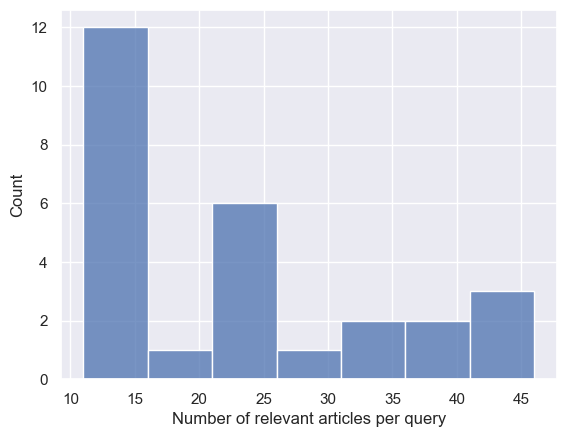

In [38]:
# Count relevant articles
relevant_document_counts: pd.DataFrame = mapping_df.groupby(by='query_id').count().reset_index()
relevant_document_counts['Number of relevant articles per query'] = relevant_document_counts['doc_id']
    
sns.histplot(relevant_document_counts, x='Number of relevant articles per query', binwidth=5)
plt.show()

### The Tasks

Task descriptions assume that you use pandas to store data.

**a)** (1 Point) Preprocessing:
Use spaCy to lemmatize the queries and documents.
* For queries, the `query` field must be lemmatized
* For documents, the concatenation of `title` and `abstract` must be lemmatized. We combine both fields (`title` and `abstract`) to simplify IR, by applying it on this single text for documents.

Store the lemmatized text in a separate column.

* you don't have to apply other pre-processing such as lower-casing
* you don't have to pay attention to cases which Spacy does not correctly lemmatize

Finally output the preprocessed pd.DataFrame query and documents.


In [51]:
from typing import Dict, List, Tuple, Mapping

def preprocessing(queries: pd.DataFrame, documents: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Use spaCy to lemmatize the queries and documents.
    * For queries, the `query` field must be lemmatized
    * For documents, the concatenation of `title` and `abstract` must be lemmatized. 
    We combine both fields (`title` and `abstract`) to simplify IR, by applying it on this single text for documents.

    Store the lemmatized text in a separate column 'content' for both input.

    * you don't have to apply other pre-processing such as lower-casing
    * you don't have to pay attention to cases which Spacy does not correctly lemmatize

    Finally output the preprocessed pd.DataFrame query and documents.
    

    :param queries: i.g. queries_df
    :param documents: i.g. documents_df
    :return queries: pd.DataFrame(pd.DataFrame.columns=['id', 'query', 'content'])
            documents: pd.DataFrame(pd.DataFrame.columns=['id', 'title', 'abstract', 'content'])
    """
    
    queries['content']=queries['query'].apply(nlp)
    def lemmaize(sent):
        return ' '.join([word.lemma_ for word in sent])
    queries['content']=queries['content'].apply(lemmaize)
    documents['content']=documents['title']+' '+documents['abstract']
    documents['content']=documents['content'].apply(nlp)
    documents['content']=documents['content'].apply(lemmaize)

    return queries, documents

In [52]:
# Test whether the preprocessing is corret
# Don't delete any given cells in homework
queries_proc, documents_proc = preprocessing(queries_df, documents_df)
selector_1: pd.Series = documents_proc['id'] == 1255
result_1 = documents_proc[selector_1].iloc[0]['content']
selector_2: pd.Series = queries_proc['id'] == 11
result_2 = queries_proc[selector_2].iloc[0]['content']
assert "Testing and Analysis" in result_1
assert "this volum" in result_1
assert "non - relevant" in result_1
assert "what be the need" in result_2
assert "research ?" in result_2

In [53]:
# Test whether  title+content is correct concatenated
# Don't delete any given cells in homework
assert "Indexing Systems this volume continue" in result_1

**b)** (4 Points) In task 2 you had to implement TF-IDF on your own. However, sklearn already provides a very efficient implementation of this functionality. Therefore, you may use  [`TfidfVectorizer()`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) in this task.

Implement the function `compute_cosine_similarity_for_all`. It shall compute the cosine similarity of *all* queries with *all* documents, and add a label describing whether the document is relevant (`True`) to the query or not (`False`). It shall return a new dataframe and represent each `query`-`document` combination as one row.

**Example output:**

In [54]:
pd.DataFrame({
    'query_id': [99,99], # The same query is compared to ...
    'document_id': [1,2], # ... different documents. In your case to all documents.
    'document_title': ['Learn about IR in NLP4Web', 'Learn about nursing somewhere else'], # You can omit this - document_id is sufficient
    'query': ['Where can I learn more about IR?'] * 2, # You can omit this - query_id is sufficient
    'similarity': [0.349, 0.025], # Cosine similarity (These values are only an example and made up)
    'is_relevant': [True, False] # Gold Labels
})
# For all combinations of (query, document)

query_id  document_id                      document_title  \
0        99            1           Learn about IR in NLP4Web   
1        99            2  Learn about nursing somewhere else   

                              query  similarity  is_relevant  
0  Where can I learn more about IR?       0.349         True  
1  Where can I learn more about IR?       0.025        False

The function takes all data (queries, document, mapping) together with the vectorizer as input.
* The vectorizer (`vectorizer`) is a vectorizer (such as [`TfidfVectorizer()`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) from `sklearn`) and converts all texts into vectors.

The method should:
1. Fit the vectorizer *on the documents* (based on the preprocessed column).
2. Compute the vectors for all *queries* using the vectorizer from (1).
3. Compute the cosine similarity between all query- and all document-vectors. You can use the function [`cosine_similarity`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) from `sklearn`.
4. Add label `is_relevant` describing for each combination of query-document whether the document is relevant to the query or not. Note that this label is independent of the computed cosine similarity score (check mapping_400.tsv instead).
5. Return the resulting dataframe. Make sure to include at least the ids for document and query, and the two newly introduced columns (`is_relevant`, `similarity`).

Apply the function to all preprocessed queries and all documents using the `TfidfVectorizer()` from `sklearn`.

Pay attention to whether fit method is used when the doc/query is verctrozied according to (1) and (2).

Finally after the function is implemented, show the titles of the ten most similar articles together with the similarity score and relevance for the query with `id=13`.

In [92]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import collections
import numpy as np
from scipy.sparse import csr_matrix

def compute_cosine_similarity_for_all(documents: pd.DataFrame, queries: pd.DataFrame, mapping: pd.DataFrame, 
                                      vectorizer: TfidfVectorizer) -> pd.DataFrame:
    """Compute cosine similarity for all query-document pairs
    
    :param documents: structure that contains document content
    :param queries: structure that contains query content
    :param mapping: structure that that contains mapping between queries and relevant documents
    :param vectorizer: TfidfVectorizer
    :return: DataFrame that contains cosine similarity for all query-document pairs
             (see example output above for how the DataFrame should look like)
    """
    result = pd.DataFrame([],columns=['document_id', 'query_id', 'similarity', 'document_title', 'query',
       'is_relevant'])
  
    documents['vector']=list(vectorizer.fit_transform( documents.loc[:,'content']))
    queries['vector']=list(vectorizer.transform( queries.loc[:,'content']))
    for index,document in documents.iterrows():
      vectoredDoc=document['vector']
      for index,query in queries.iterrows():
         vectoredQuery=query['vector']
         relevant=False
         if (mapping[(mapping["doc_id"]==document["id"]) & (mapping["query_id"]== query["id"]	)].shape[0]>0):
            relevant=True

         list_row=[document["id"],query["id"],cosine_similarity(vectoredDoc,vectoredQuery)[0][0],document["title"],query["query"],
         relevant]
         result.loc[len(result)] = list_row  

    
    # YOUR CODE HERE
    
    return result

similarity_results: pd.DataFrame = compute_cosine_similarity_for_all(documents_df, queries_df, mapping_df, 
                                                                     TfidfVectorizer())

In [130]:
"""
Show/print the titles of the ten most similar articles together with the similarity score and 
relevance for the query with `id=13`.
"""
# Don't delete any given cells in homework
print(similarity_results[similarity_results['query_id']==13].sort_values(by=['similarity','is_relevant'],ascending=False)['document_title'].iloc[:10])
# YOUR CODE HERE

1298     What Information Dissemination Studies Imply C...
8480         Popper's Mystification of Objective Knowledge
1190     Computerized Information Retrieval Services (A...
6293       Data Retrieval Systems:  Specifics and Problems
2189     Integrated Information Processing and the Case...
3620     Evaluation of an SDI Service Based on the Inde...
10721           Design of Information Systems and Services
10613                   Adaptive Information Dissemination
7670                                         Opinion Paper
7967     The Cost_Performance of an On-Line, Free-Text ...
Name: document_title, dtype: object


In [93]:
# Test whether the columns of returned dataframe meets the requirement
assert (similarity_results.columns == ['document_id', 'query_id', 'similarity', 'document_title', 'query',
       'is_relevant']).all()

# Test whether 'is_relevant' column is correct.
# Don't delete any given cells in homework
assert similarity_results[(similarity_results['query_id']==13)& \
                          (similarity_results['document_id']==611)].is_relevant.item() == False
assert similarity_results[(similarity_results['query_id']==13)& \
                          (similarity_results['document_id']==1314)].is_relevant.item() == False
assert similarity_results[(similarity_results['query_id']==13)& \
                          (similarity_results['document_id']==1078)].is_relevant.item() == False
assert similarity_results[(similarity_results['query_id']==13)& \
                          (similarity_results['document_id']==731)].is_relevant.item() == True
assert similarity_results[(similarity_results['query_id']==15)& \
                          (similarity_results['document_id']==611)].is_relevant.item() == False
assert similarity_results[(similarity_results['query_id']==15)& \
                          (similarity_results['document_id']==255)].is_relevant.item() == False
assert similarity_results[(similarity_results['query_id']==15)& \
                          (similarity_results['document_id']==437)].is_relevant.item() == False
assert similarity_results[(similarity_results['query_id']==15)& \
                          (similarity_results['document_id']==1353)].is_relevant.item() == True

In [94]:
# Test whether similarity is correct computed
# Don't delete any given cells in homework
assert (abs(similarity_results[(similarity_results['query_id']==13)& \
           (similarity_results['document_id']==611)]['similarity'] - 0.323800)<1e-6).item()
assert (abs(similarity_results[(similarity_results['query_id']==13)& \
           (similarity_results['document_id']==1314)]['similarity'] - 0.256249)<1e-6).item()
assert (abs(similarity_results[(similarity_results['query_id']==13)& \
           (similarity_results['document_id']==1078)]['similarity'] - 0.248833)<1e-6).item()
assert (abs(similarity_results[(similarity_results['query_id']==13)& \
           (similarity_results['document_id']==1136)]['similarity'] - 0.247530)<1e-6).item()
assert (abs(similarity_results[(similarity_results['query_id']==15)& \
           (similarity_results['document_id']==611)]['similarity'] - 0.238587)<1e-6).item()
assert (abs(similarity_results[(similarity_results['query_id']==15)& \
           (similarity_results['document_id']==255)]['similarity'] - 0.228097)<1e-6).item()
assert (abs(similarity_results[(similarity_results['query_id']==15)& \
           (similarity_results['document_id']==437)]['similarity'] - 0.221773)<1e-6).item()
assert (abs(similarity_results[(similarity_results['query_id']==15)& \
           (similarity_results['document_id']==979)]['similarity'] - 0.216593)<1e-6).item()

**c)** (3 Points) Implement the function `precision_recall` to compute precision and recall for every row from the results of 3b). Precision and recall should be computed as discussed in the lecture for the P-R curve (without interpolation): Compute both metrics for each of the steps (top $1$ results, top $2$ results, ...., top $n$ results) and for each query (not aggregated yet). Assume that documents are ranked/retrieved according to the similarity score. Add the precision and recall values to the dataframe (or similar).

The input to this function should be the resulting dataframe from 3b). Apply it on the data.

Compare with dataframe from 3b), the output of 3c) function has two addtional columns(i.e. 'precision', 'recall')

Finally, show (similar to 3b) the top 10 results for the query with `id=13` together with the precision and recall metrics.

In [155]:
from sklearn.metrics import precision_recall_curve

def precision_recall(similarity_results: pd.DataFrame) -> pd.DataFrame:
    """Compute precision and recall for each query for each of the steps (top 1 results, ...., top 𝑛 results)
    
    :param similarity_results: resulting DataFrame from 3b)
                               (contains information from all queries and not only the information from the query
                                with id=13)
    :return: structure that contains precision and recall for each query for each of the steps                      
    """
    result = pd.DataFrame([],columns=['document_id', 'query_id', 'similarity', 'document_title', 'query',
       'is_relevant', 'precision', 'recall'])
    
    # YOUR CODE HERE
    result=similarity_results.copy()
    result=result.sort_values(by=['query_id','similarity'],ascending=False)

    truePos=0
    Pos=0
    precision=[]
    recall=[]
    lastQuerynum=-1
    for index,row in result.iterrows():
        if (row['query_id']!=lastQuerynum):
            if (truePos>0):
                for i in range(0,Pos):
                    recall[len(recall)-Pos+i]=recall[len(recall)-Pos+i]/truePos
            truePos=0
            Pos=0
            lastQuerynum=row['query_id']     
        if (row['is_relevant']):
            truePos+=1
      
        Pos+=1
    
        if (Pos>0):
            precision.append(truePos/Pos)
        else:
            precision.append(0)
        
        recall.append(truePos)
    if (truePos>0):
        for i in range(0,Pos):
            recall[len(recall)-Pos+i]=recall[len(recall)-Pos+i]/truePos
  
    result["precision"]=precision
    result["recall"]=recall
    return result

similarity_results: pd.DataFrame = compute_cosine_similarity_for_all(documents_df, queries_df, mapping_df, 
                                                                     TfidfVectorizer())
pr_similarity_results: pd.DataFrame = precision_recall(similarity_results)

In [132]:
"""
Show/print (similar to 3b) the top 10 results for the query with `id=13` together with the precision and 
recall metrics.
"""
# Don't delete any given cells in homework
pr_similarity_results[pr_similarity_results['query_id'] == 13].iloc[:10]
# YOUR CODE HERE


document_id  query_id  similarity  \
1298           611        13    0.323800   
8480          1314        13    0.256249   
1190          1078        13    0.248833   
6293          1136        13    0.247530   
2189           481        13    0.241226   
3620           731        13    0.224721   
10721          135        13    0.224606   
10613           49        13    0.216577   
7670            59        13    0.216387   
7967           523        13    0.215974   

                                          document_title  \
1298   What Information Dissemination Studies Imply C...   
8480       Popper's Mystification of Objective Knowledge   
1190   Computerized Information Retrieval Services (A...   
6293     Data Retrieval Systems:  Specifics and Problems   
2189   Integrated Information Processing and the Case...   
3620   Evaluation of an SDI Service Based on the Inde...   
10721         Design of Information Systems and Services   
10613                 Adaptive Information Dissemination   
7670                                       Opinion Paper   
7967   The Cost_Performance of an On-Line, Free-Text ...   

                                                   query  is_relevant  \
1298   What criteria have been developed for the obje...        False   
8480   What criteria have been developed for the obje...        False   
1190   What criteria have been developed for the obje...        False   
6293   What criteria have been developed for the obje...        False   
2189   What criteria have been developed for the obje...        False   
3620   What criteria have been developed for the obje...         True   
10721  What criteria have been developed for the obje...        False   
10613  What criteria have been developed for the obje...         True   
7670   What criteria have been developed for the obje...         True   
7967   What criteria have been developed for the obje...         True   

       precision    recall  
1298    0.000000  0.000000  
8480    0.000000  0.000000  
1190    0.000000  0.000000  
6293    0.000000  0.000000  
2189    0.000000  0.000000  
3620    0.166667  0.043478  
10721   0.142857  0.043478  
10613   0.250000  0.086957  
7670    0.333333  0.130435  
7967    0.400000  0.173913

In [124]:
abs(result_5[abs(result_5['similarity'] - 0.224721)<1e-6]['precision'])

3620    0.166667
Name: precision, dtype: float64

In [121]:
# Test whether the columns of returned dataframe meets the requirement
# Don't delete any given cells in homework
assert (pr_similarity_results.columns == ['document_id', 'query_id', 'similarity', 'document_title', 'query',
       'is_relevant', 'precision', 'recall']).all()

# Test whether metrics are computed based on the ordered top similarity
def IsListSorted_sorted(lst):
    return sorted(lst) == lst or sorted(lst, reverse=True) == lst
__lst= list(pr_similarity_results[pr_similarity_results['query_id'] == 15].similarity)
assert IsListSorted_sorted(__lst)

In [167]:
# Test whether precision or recall are computed incorrectly
# Don't delete any given cells in homework
similarity_results: pd.DataFrame = compute_cosine_similarity_for_all(documents_df, queries_df, mapping_df, 
                                                                     TfidfVectorizer())
pr_similarity_results: pd.DataFrame = precision_recall(similarity_results)
result_5 =pr_similarity_results[pr_similarity_results['query_id'] == 13]
(abs(result_5[abs(result_5['similarity'] - 0.323800)<1e-6]['precision']-0) < 1e-6).item()
assert (abs(result_5[abs(result_5['similarity'] - 0.224721)<1e-6]['precision']-0.166667) < 1e-6).item() 
assert (abs(result_5[abs(result_5['similarity'] - 0.224721)<1e-6]['recall']-0.043478) < 1e-6).item() 
assert (abs(result_5[abs(result_5['similarity'] - 0.224606)<1e-6]['precision']-0.142857) < 1e-6).item() 
assert (abs(result_5[abs(result_5['similarity'] - 0.224606)<1e-6]['recall']-0.043478) < 1e-6).item() 
assert (abs(result_5[abs(result_5['similarity'] - 0.216387)<1e-6]['precision']-0.333333) < 1e-6).item() 
assert (abs(result_5[abs(result_5['similarity'] - 0.216387)<1e-6]['recall']-0.130435) < 1e-6).item() 
assert (result_5[abs(result_5['similarity'] - 0.216387)<1e-6]['document_title'].item() == 'Opinion Paper')

**d)** (3 Points) Implement the function `precision_recall_11_point` for 11 point interpolation. It should compute interpolated precision values for all 11 recall levels and output them as a dataframe. Choose the first sample at which the recall $\geq$ recall_level to divide  your results into these 11 points. For example: When selecting samples for recall_level $0.1$ and you only have recall values of $[0.095, 0.112]$, then select the second point (recall $0.112$) as start for this recall level.

Apply this function on all queries, given the output of 3c) and output the precision values at each recall level of the 11-point interpolation for the query with `id=13`. 

_Note_: Please make sure you correctly understand the following metrics before implementing this task (Information Retrieval II slides pp.20-24). Feel free to ask questions in the forum:

* interpolated precision
* 11-point interpolated precision

The returend pd.DataFrame has 3 columns: "Query", "Recall", "Precision".

"Query": query_id

"Recall": recall level (i.e. 100, 90, ...0)

"Precision": float

In [180]:
def precision_recall_11_point(pr_similarity_results: pd.DataFrame) -> pd.DataFrame:
    """Perform 11 point interpolation on data in pr_similarity_results
    
    :param pr_similarity_results: resulting DataFrame from 3c)
    :return DataFrame that contains 11 point interpolations for all queries
    The returend pd.DataFrame has 3 columns: "Query", "Recall", "Precision".
    "Query": query_id
    "Recall": recall level (i.e. 100, 90, ...0)
    "Precision": floa
    """
    result = pd.DataFrame([],columns = ['Query', 'Recall', 'Precision'])
    maximum=0
    Pos=0
    lastQuerynum=-1
    thisQueue=[]
    for index,row in pr_similarity_results.iterrows():
        if (row['query_id']!=lastQuerynum):
            if (Pos>0):
                maximum=0
                levelnow=100
          
                for i in range(0,Pos):
                    while( thisQueue[Pos-1-i]["recall"]<levelnow/100):
                        
                        result.loc[len(result)]=[lastQuerynum,levelnow,maximum]
                        levelnow-=10
                     

                  
                    if (thisQueue[Pos-i-1]["precision"]>maximum):
                        maximum=thisQueue[Pos-i-1]["precision"]
                  
                    
                    
             
                result.loc[len(result)]=[lastQuerynum,levelnow,maximum]
            lastQuerynum=row['query_id']
            thisQueue=[]
            Pos=0
        
                            

        Pos+=1
        thisQueue.append(row)
    maximum=0

    levelnow=100

    for i in range(0,Pos):
        while( thisQueue[Pos-1-i]["recall"]<levelnow/100):
         
            result.loc[len(result)]=[lastQuerynum,levelnow,maximum]
            levelnow-=10
            Precision=0
            precisionNum=0

    
        if (thisQueue[Pos-1-i]["precision"]>maximum):
            maximum=thisQueue[Pos-1-i]["precision"]
     

    result.loc[len(result)]=[lastQuerynum,levelnow,maximum]

    return result
    
    # YOUR CODE HERE
    

pr_11_point: pd.DataFrame = precision_recall_11_point(pr_similarity_results)

In [181]:
pr_11_point

Query  Recall  Precision
0    109.0   100.0   0.061697
1    109.0    90.0   0.070968
2    109.0    80.0   0.076628
3    109.0    70.0   0.092391
4    109.0    60.0   0.097561
..     ...     ...        ...
292    1.0    40.0   0.260870
293    1.0    30.0   0.384615
294    1.0    20.0   0.384615
295    1.0    10.0   0.666667
296    1.0     0.0   1.000000

[297 rows x 3 columns]

In [186]:
"""
Output/print the precision values at each recall level of the 11-point interpolation for the query with `id=13`. 
"""
# Don't delete any given cells in homework



# YOUR CODE HERE
pr_11_point[pr_11_point['Query'] == 13]

Query  Recall  Precision
264   13.0   100.0   0.062162
265   13.0    90.0   0.115385
266   13.0    80.0   0.116959
267   13.0    70.0   0.147826
268   13.0    60.0   0.269231
269   13.0    50.0   0.333333
270   13.0    40.0   0.333333
271   13.0    30.0   0.333333
272   13.0    20.0   0.357143
273   13.0    10.0   0.400000
274   13.0     0.0   0.400000

In [182]:
# Test whether the columns of returned dataframe meets the requirement
# Don't delete any given cells in homework
assert (pr_11_point.columns == ['Query', 'Recall', 'Precision']).all()

# Test whether precision values and recall level have different order
def IsListSorted_sorted_2list(lst_1, lst_2):
    return (sorted(lst_1) == lst_1 and sorted(lst_2, reverse=True) == lst_2) \
            or (sorted(lst_1, reverse=True) == lst_1 and sorted(lst_2) == lst_2)
__lst_1= list(pr_11_point[pr_11_point['Query'] == 15].Recall)
__lst_2= list(pr_11_point[pr_11_point['Query'] == 15].Precision)
assert IsListSorted_sorted_2list(__lst_1, __lst_2)

In [184]:
# Test
_id = 15
pr_11_point: pd.DataFrame = precision_recall_11_point(pr_similarity_results)
result_6 = pr_11_point[pr_11_point['Query'] == _id]
assert abs(result_6[result_6['Recall']==100]['Precision'].item() - 0.061452) < 1e-6
assert abs(result_6[result_6['Recall']==90]['Precision'].item() - 0.068493) < 1e-6
assert abs(result_6[result_6['Recall']==80]['Precision'].item() - 0.074689) < 1e-6
assert abs(result_6[result_6['Recall']==70]['Precision'].item() - 0.094118) < 1e-6
assert abs(result_6[result_6['Recall']==60]['Precision'].item() - 0.109375) < 1e-6
assert abs(result_6[result_6['Recall']==50]['Precision'].item() - 0.142857) < 1e-6

Plot the interpolated P-R curve based on all queries. (Use the result from 3d)

Just see the result through your computation.

<AxesSubplot: xlabel='Recall', ylabel='Precision'>

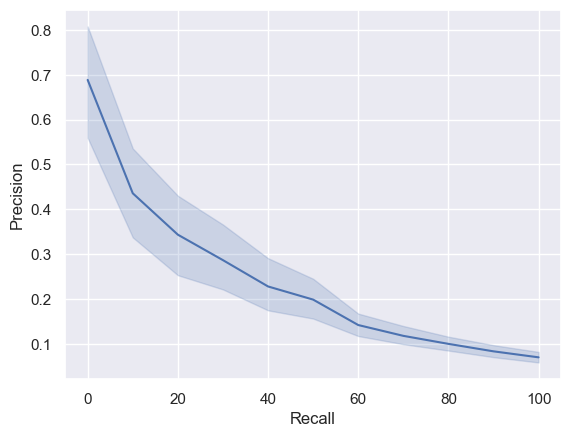

In [185]:
sns.lineplot(
    data=pr_11_point,
    x='Recall',
    y='Precision'
)

**Submission:**

Please upload your submission to Moodle before the next exercise session <font color="red">(Jan 11th, 23:59pm)</font>!

Submission format: `Group_XX_Exercise_XX.zip`

Your submission should contain your filled out Jupyter notebook (naming schema: `NLP4Web_Home_Exercise4.ipynb`) and any auxiliar files that are necessary to run your code (e.g., the datasets provided by us).

Each submission must be handed in only once per group.